<a href="https://colab.research.google.com/github/Adrok24/Proyecto-Integrador/blob/main/VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inteligencia Artificial

# Clase 22 - Modelos generativos 2
## Autoencoders variacionales

En esta práctica replicaremos la estructura del autoencoder pero agregándo una modificación para que el espacio en el que se ubican las representaciones intermedias de las imágenes del dataset sea (localmente) continuo.

La primera parte de esta notebook replica la notebook anterior, hasta la parte en la que construimos el encoder.

In [ ]:
import os, pickle

notebook_dir = os.getcwd()
faces_dir = os.path.join(notebook_dir, "data_faces/img_align_celeba")
attrs_file = os.path.join(notebook_dir, "list_attr_celeba.txt")

In [ ]:
n_images = len(os.listdir(faces_dir))
n_images

202496

In [ ]:
import pandas as pd

In [ ]:
attrs_df = pd.read_csv(attrs_file, delim_whitespace=True, skiprows=1)

In [ ]:
attrs_df.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
os.listdir(faces_dir)[:10]

['199883.jpg',
 '100582.jpg',
 '079585.jpg',
 '196701.jpg',
 '070196.jpg',
 '028488.jpg',
 '072821.jpg',
 '092815.jpg',
 '192858.jpg',
 '188688.jpg']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def get_attrs(filename):
    row = attrs_df.loc[filename, :]
    return [attr for attr in row.index if row[attr]==1]

In [ ]:
get_attrs(os.listdir(faces_dir)[0])

['Arched_Eyebrows',
 'Attractive',
 'Brown_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Mouth_Slightly_Open',
 'No_Beard',
 'Pointy_Nose',
 'Smiling',
 'Straight_Hair',
 'Wearing_Lipstick',
 'Young']

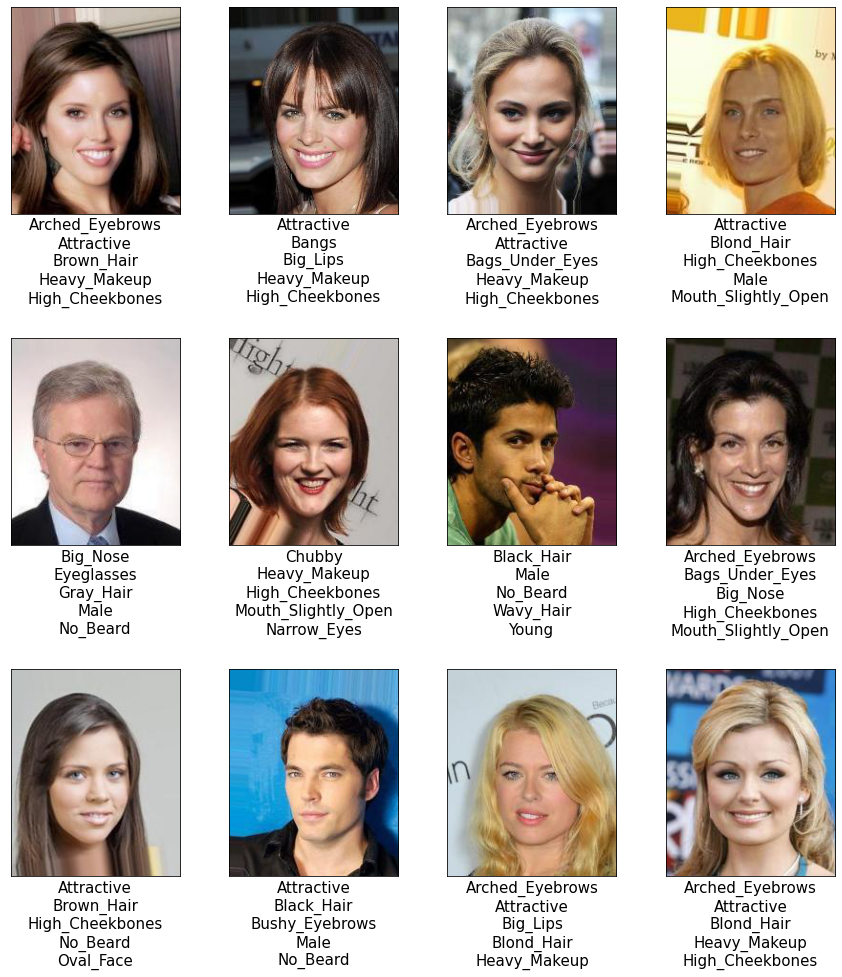

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(15,16))
fig.subplots_adjust(hspace=0.6)
for i, ax in enumerate(axes.flatten()):
    filename = os.listdir(faces_dir)[i]
    img = plt.imread(os.path.join(faces_dir, filename))
    ax.imshow(img)
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.set_xlabel("\n".join(get_attrs(filename)[:5]), fontsize=15)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size=128
data_flow = data_gen.flow_from_directory(os.path.join(faces_dir,os.pardir), 
                                         class_mode=None, 
                                         batch_size=batch_size,
                                         target_size=(128,128)                        
                                        )

Found 202496 images belonging to 1 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Layer
from tensorflow.keras.layers import Conv2DTranspose, Lambda, Dropout
from tensorflow.keras.layers import LeakyReLU, Activation, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import cv2
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint 


## El autoencoder variacional

Vamos a generar nuestra propia clase de modelo, heredando de la clase `Model` de Keras para que sea compatible con todos sus métodos, particularmente `.fit()`. La ventaja que nos da este método, es que podemos definir nuestro propio loop de entrenamiento y hacer que se invoque diréctamente cuando ejecutemos `model.fit()`.

Esta clase estará compuesta por 2 modelos independientes que trabajarán en conjunto para brindar la funcionalidad completa del Autoencoder Variacional.

In [ ]:
class VAEModel(Model):
    def __init__(self, encoder, decoder, r_loss_factor, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.r_loss_factor = r_loss_factor

    # Definimos el train step para que utilice la función de costo compuesta por el error de reconstrucción y la divergencia KL
    def train_step(self, data):
        # Verificamos que los datos de entrada sean sólo imágenes
        if isinstance(data, tuple):
            data = data[0]
        
        # Iniciamos el cálculo de la loss dentro del contexto que registra las operaciones para poder derivarlas
        with tf.GradientTape() as tape:
            # Usamos el encoder para mapear las imágenes al espacio latente y obtenemos los parámetros de la distribución
            z_mean, z_log_var, z = self.encoder(data)
            # Reconstruimos la imágen a partir de z
            reconstruction = self.decoder(z)
            # Calculamos la pérdida de reconstrucción con el MSE
            reconstruction_loss = tf.reduce_mean(
                tf.square(data - reconstruction), axis = [1,2,3]
            )
            # Escalamos la pérdida con el r_loss_factor
            reconstruction_loss *= self.r_loss_factor
            # Calculamos la divergencia KL usando la media y la varianza
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_sum(kl_loss, axis = 1)
            kl_loss *= -0.5
            # Combinamos las pérdidas
            total_loss = reconstruction_loss + kl_loss
        # Calculamos los gradientes
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Actualizamos los pesos
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # El método train_step debe devolver un diccionario
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    
    def call(self,inputs):
        mu, logvar, z = self.encoder(inputs)
        return self.decoder(z)
    
    # Definimos nuestra propia función para persistir el modelo
    def save(self, folder):
        # Creamos la carpeta si no existe
        if not os.path.isdir(folder):
            os.mkdir(folder)
        # Guardamos el encoder
        self.encoder.save(os.path.join(folder, 'encoder.h5'))
        # Guardamos el decoder
        self.decoder.save(os.path.join(folder, 'decoder.h5'))
        # Guardamos el r_loss_factor
        with open(os.path.join(folder, 'r_loss_factor.pkl'), 'wb') as f:
            pickle.dump(self.r_loss_factor, f)
    
    # Definimos nuestra propia función para cargar un modelo existente
    def load(self, folder, Sampling):
        # Cargamos el encoder, indicando que tenemos un objecto custom, que es la capa Sampling
        self.encoder = tf.keras.models.load_model(os.path.join(folder, 'encoder.h5'), custom_objects={'Sampling': Sampling})
        # Cargamos el decoder
        self.decoder = tf.keras.models.load_model(os.path.join(folder, 'decoder.h5'))
        # Cargamos el r_loss_factor
        with open(os.path.join(folder, 'r_loss_factor.pkl'), 'rb') as f:
            self.r_loss_factor = pickle.load(f)
            


En este caso, la red del encoder debe generar la salida a partir de los valores $\mu$ y $\sigma$, tomando una muestra aleatoria. Para eso definimos la capa `Sampling` que la inocrporaremos al modelo como una capa común y corriente, solo que realizará la operación que nosotros definamos.

In [ ]:
class Sampling(Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon

In [ ]:
# Definimos la dimensión de las imágenes de entrada
input_dim = (128,128,3)
# Definimos la dimensionalidad del espacio latente
latent_dim = 200

Vamos a usar la API funcional para armar el encoder. La estructura convolucional es la misma, pero le agregaremos capas finales para tener el comportamiento variacional:
- tendremos una salida para la media
- tendremos una salida para el logaritmo de la varianza
- usaremos estos parámetros como input de la capa Sampling para tomar una muestra parametrizada del espacio latente

In [ ]:
# Creamos la capa de entrada
encoder_input = Input(shape=input_dim, name='encoder_input')

x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', name = 'encoder_conv_0')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same', name = 'encoder_conv_1')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same', name = 'encoder_conv_2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same', name = 'encoder_conv_3')(x)
x = BatchNormalization()(x)
x = LeakyReLU(name='before_flattening')(x)
shape_before_flattening = K.int_shape(x)[1:]

x = Flatten(name='flatten')(x)

# Generamos la media
mu = Dense(latent_dim, name='mu')(x)
# Generamos el logaritmo de la varianza
logvar = Dense(latent_dim, name='logvar')(x)
# Usamos esos parámetros para samplear el espacio latente
z = Sampling(name='encoder_output')([mu, logvar])


# Armamos el modelo con sus 3 salidas
encoder = Model(encoder_input, [mu, logvar, z])

El decoder no cambia y lo crearemos usando la API Secuencial.

In [ ]:
decoder = Sequential(name='decoder')
# Debemos reconstruir el camino inverso del encoder
decoder.add(Dense(np.prod(shape_before_flattening), input_shape=(latent_dim,)))
decoder.add(Reshape(shape_before_flattening))

decoder.add(Conv2DTranspose(
                filters = 64,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'decoder_conv_t_0'
                ))
decoder.add(BatchNormalization())
decoder.add(LeakyReLU())

decoder.add(Conv2DTranspose(
                filters = 64,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'decoder_conv_t_1'
                ))
decoder.add(BatchNormalization())
decoder.add(LeakyReLU())

decoder.add(Conv2DTranspose(
                filters = 32,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'decoder_conv_t_2'
                ))
decoder.add(BatchNormalization())
decoder.add(LeakyReLU())

# Volvemos a llevar la imagen reconstruida a 3 canales 
decoder.add(Conv2DTranspose(
                filters = 3,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'decoder_conv_t3'
                ))

# En este caso necesitamos que la salida esté entre 0 y 1
decoder.add(Activation("sigmoid"))

Es importante notar que, si bien el decoder tiene un único input z (la muestra del espacio latente), el encoder tiene que generar las 3 salidas para poder calcular las funciones de pérdida.

Ahora podemos instanciar el VAE completo

In [ ]:
vae = VAEModel(encoder, decoder, 10000)

In [ ]:
# Compilamos
vae.compile(Adam(1e-4), metrics='loss')

In [ ]:
# Entrenamos
vae.fit(data_flow, batch_size=batch_size, epochs=20, steps_per_epoch=len(data_flow))

Epoch 1/20
1582/1582 [==============================] - 139s 88ms/step - loss: 195.2927 - reconstruction_loss: 134.0049 - kl_loss: 61.2878
Epoch 2/20
1582/1582 [==============================] - 140s 89ms/step - loss: 195.2080 - reconstruction_loss: 133.8961 - kl_loss: 61.3119
Epoch 3/20
1582/1582 [==============================] - 140s 89ms/step - loss: 195.0984 - reconstruction_loss: 133.8216 - kl_loss: 61.2769
Epoch 4/20
1582/1582 [==============================] - 140s 88ms/step - loss: 195.0072 - reconstruction_loss: 133.6931 - kl_loss: 61.3141
Epoch 5/20
1582/1582 [==============================] - 141s 89ms/step - loss: 194.9320 - reconstruction_loss: 133.6564 - kl_loss: 61.2756
Epoch 6/20
1582/1582 [==============================] - 141s 89ms/step - loss: 194.8367 - reconstruction_loss: 133.5402 - kl_loss: 61.2965
Epoch 7/20
1582/1582 [==============================] - 142s 90ms/step - loss: 194.7222 - reconstruction_loss: 133.4520 - kl_loss: 61.2701
Epoch 8/20
1582/1582 [=====

Evaluemos el modelo como autoencoder

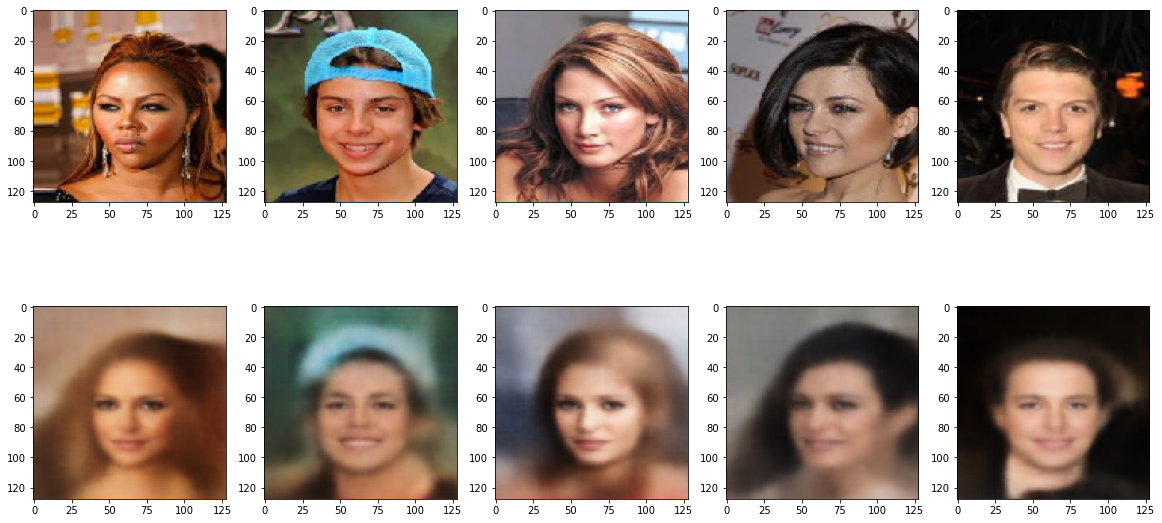

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20,10))
img = data_flow.next()[:5]
decoded = vae(img)
for i in range(5):
    ax[0][i].imshow(img[i,:,:,:])
    ax[1][i].imshow(decoded[i,:,:,:])

In [ ]:
vae.save('./trained_vae')

Ahora observemos la capacidad del modelo de generar rostros nuevos

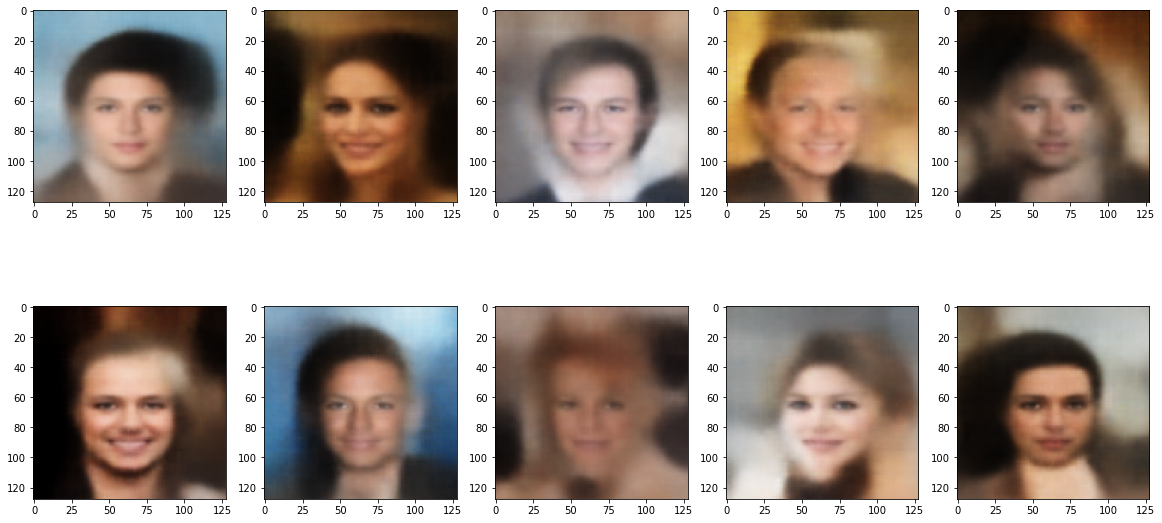

In [ ]:
# Tomamos muestras aleatorias del espacio latente
z_sampled = tf.random.normal(shape=(10, 200))
# Las decodificamos para generar imágenes
decoded = vae.decoder(z_sampled)
# Ploteamos
fig, ax = plt.subplots(2, 5, figsize=(20,10))
for i in range(5):
    ax[0][i].imshow(decoded[i+5,:,:,:])
    ax[1][i].imshow(decoded[i,:,:,:])

¿Qué podemos concluir de la comparación entre los AE y los VAE? Aspectos a analizar:
- Definición de las imágenes (nítidas, blurreadas?)
- Desempeño como regenerador de imágenes (output = input?)
- Desempeño como algoritmo generativo (output creíble?)

## Analizando el espacio latente

El hecho de incorporarle la divergencia de Kullback-Leibler como término de regularización en la función de costo, hace que el espacio latente al que se mapean las imágenes de entrada sea altamente estructurado, a diferencia del espacio de los autoencoders convencionales.

Lo que haremos a continuación es analizar esta estructura, a partir de los atributos de cada imágen que viene con el dataset.

In [ ]:
attrs_df = attrs_df.reset_index().rename(columns={'index': 'filename'})
attrs_df.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


Si bien no hay una interpretación para cada dimensión del espacio latente (simplemente no son valores interpretables), podemos encontrar estructura en el espacio si analizamos dónde se ubican las imágenes que tengan cierta característica y dónde se ubican las que no la tienen. Promediando las ubicaciones de ambos grupos de imágenes y luego buscando el vector que las une, estamos identificando una dirección en el espacio latente que representa dicha característica.

Armemos una función que realice estas operaciones:

In [ ]:
def get_latent_vector(df, col, img_folder):
    # Preparamos el flujo de imágenes
    data_gen = ImageDataGenerator(rescale=1./255)
    # En este caso, queremos saber si las imágenes tienen o no una determinada característica. Para eso usaremos el "target".
    data_flow = data_gen.flow_from_dataframe(df, directory=img_folder, x_col='filename', y_col=col, class_mode='raw', target_size=(128, 128), batch_size=512)
    
    # Creamos vectores en 0 para ir acumulando resultados parciales
    origin = np.zeros(shape = latent_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = latent_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = latent_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = latent_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = latent_dim, dtype = 'float32')

    current_vector = np.zeros(shape = latent_dim, dtype = 'float32')
    current_dist = 0
    
    print('label: ' + col)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    # Iteramos hasta encontrar al menos 10000 muestras con la característica
    while(current_n_POS < 10000):
        
        # Obtenemos un batch de imágenes y sus etiquetas
        batch = data_flow.next()
        im = batch[0]
        attribute = batch[1]

        # Mapeamos las imágenes
        _,_,z = vae.encoder.predict(np.array(im))

        # Separamos los vectores de aquellas imágenes con y sin la característica
        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        # Calculamos las medias de los vectores para cada grupo
        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)
            
        # Calculamos el vector entre ambas medias
        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )
        
        # Actualizamos los valores
        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)
    
        # Si las medias de ambos grupos no se movieron demasiado, frenamos la iteración
        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + col + ' vector')
            break

    return current_vector


Ahora podemos elegir una característica de las imágenes y encontrar el vector que la representa en el espacio latente

In [ ]:
smiling_vector = get_latent_vector(attrs_df, 'Smiling', faces_dir)

/home/soko/miniconda3/envs/dh-ia/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 103 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 202496 validated image filenames.
label: Smiling
images : POS move : NEG move :distance : 𝛥 distance
261    : 1.083    : 1.133    : 1.762    : 1.762
527    : 0.627    : 0.598    : 1.531    : -0.231
765    : 0.332    : 0.379    : 1.497    : -0.035
1014    : 0.242    : 0.258    : 1.459    : -0.038
1258    : 0.193    : 0.197    : 1.439    : -0.019
1505    : 0.165    : 0.176    : 1.436    : -0.004
1728    : 0.133    : 0.14    : 1.422    : -0.013
1974    : 0.112    : 0.108    : 1.413    : -0.01
2219    : 0.11    : 0.102    : 1.41    : -0.003
2472    : 0.104    : 0.086    : 1.388    : -0.022
2698    : 0.082    : 0.087    : 1.383    : -0.005
2953    : 0.078    : 0.071    : 1.391    : 0.008
3223    : 0.075    : 0.07    : 1.393    : 0.002
3474    : 0.062    : 0.06    : 1.397    : 0.004
3727    : 0.058    : 0.06    : 1.391    : -0.006
3990    : 0.06    : 0.059    : 1.384    : -0.007
4245    : 0.058    : 0.052    : 1.379    : -0.005
4472    : 0.046    : 0.057    : 1.386    : 0.007
4703    :

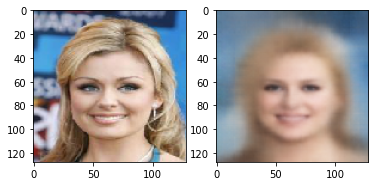

In [ ]:
test_img = data_flow.next()[0]
fig, ax = plt.subplots(1, 2)
ax[0].imshow(test_img)
ax[1].imshow(vae(np.expand_dims(test_img, axis=0))[0])

In [ ]:
_, _, encoded = vae.encoder(np.expand_dims(test_img, axis=0))

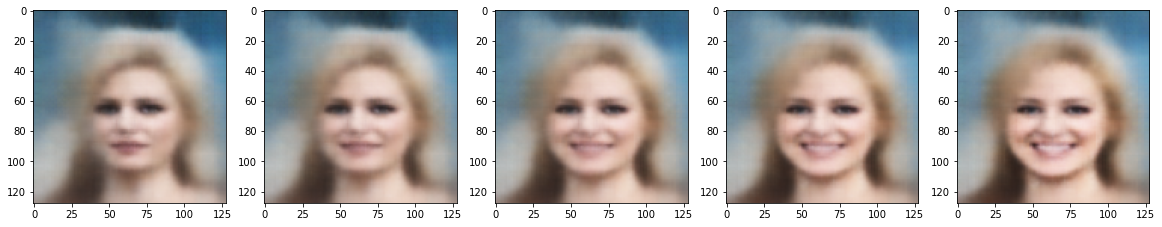

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20,5))
for i in range(5):
    decoded = vae.decoder(encoded+smiling_vector*(i-2))
    ax[i].imshow(decoded[0])

In [ ]:
attractive_vector = get_latent_vector(attrs_df, 'Attractive', faces_dir)

/home/soko/miniconda3/envs/dh-ia/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 103 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 202496 validated image filenames.
label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
271    : 1.038    : 0.97    : 1.577    : 1.577
518    : 0.644    : 0.649    : 1.301    : -0.276
772    : 0.358    : 0.337    : 1.198    : -0.103
1026    : 0.244    : 0.258    : 1.168    : -0.03
1294    : 0.196    : 0.191    : 1.136    : -0.032
1553    : 0.152    : 0.161    : 1.114    : -0.022
1803    : 0.132    : 0.134    : 1.1    : -0.014
2056    : 0.119    : 0.116    : 1.079    : -0.021
2324    : 0.116    : 0.107    : 1.054    : -0.025
2610    : 0.091    : 0.092    : 1.038    : -0.016
2849    : 0.077    : 0.09    : 1.031    : -0.006
3108    : 0.074    : 0.077    : 1.036    : 0.004
3367    : 0.07    : 0.076    : 1.036    : -0.0
3632    : 0.065    : 0.06    : 1.029    : -0.006
3914    : 0.058    : 0.055    : 1.023    : -0.007
4179    : 0.06    : 0.056    : 1.021    : -0.002
4456    : 0.053    : 0.048    : 1.022    : 0.001
4714    : 0.048    : 0.052    : 1.02    : -0.002
4971   

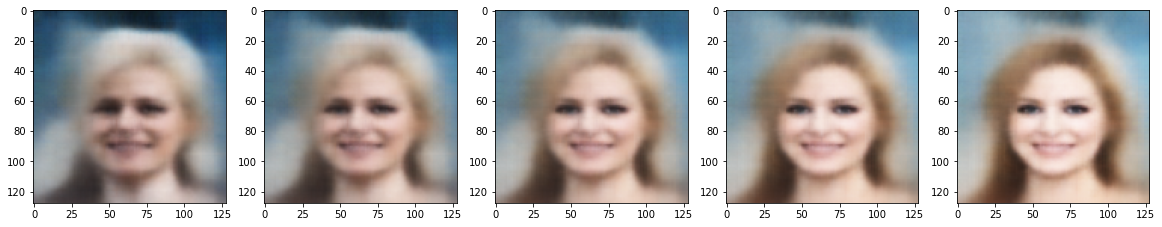

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20,5))
for i in range(5):
    decoded = vae.decoder(encoded+attractive_vector*(i-2))
    ax[i].imshow(decoded[0])

In [ ]:
bald_vector = get_latent_vector(attrs_df, 'Bald', faces_dir)

Found 202496 validated image filenames.
label: Bald
images : POS move : NEG move :distance : 𝛥 distance
12    : 5.016    : 0.718    : 5.0    : 5.0
33    : 3.415    : 0.482    : 3.29    : -1.71
44    : 1.29    : 0.268    : 2.901    : -0.389
52    : 0.854    : 0.189    : 2.789    : -0.112
62    : 0.845    : 0.138    : 2.653    : -0.136
78    : 0.834    : 0.105    : 2.478    : -0.174
92    : 0.616    : 0.091    : 2.312    : -0.166
106    : 0.491    : 0.081    : 2.199    : -0.113
113    : 0.314    : 0.073    : 2.171    : -0.028
128    : 0.439    : 0.067    : 2.137    : -0.034
141    : 0.393    : 0.058    : 2.16    : 0.023
151    : 0.326    : 0.05    : 2.144    : -0.016
171    : 0.4    : 0.046    : 2.111    : -0.033
180    : 0.253    : 0.049    : 2.075    : -0.036
188    : 0.229    : 0.043    : 2.065    : -0.01
197    : 0.222    : 0.04    : 2.042    : -0.023
208    : 0.229    : 0.039    : 2.025    : -0.017
217    : 0.216    : 0.037    : 1.994    : -0.031
228    : 0.208    : 0.034    : 1.982

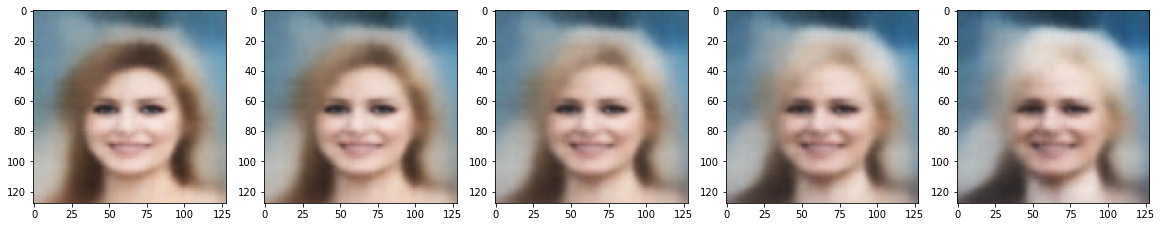

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20,5))
for i in range(5):
    decoded = vae.decoder(encoded+bald_vector*(i-2))
    ax[i].imshow(decoded[0])